# **Anomaly detection using LSTM**

## **Long Short Term Memory**






*   Recurrent neural network have vanishing gradient problem.


*   Long Short Term Memory networks capable of learning long-term dependencies using cell memory unit.



*   **LSTM has three gates to control the cell state**  - Input gate , Output gate , Forget gate








In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ambient_temperature_system_failure.txt to ambient_temperature_system_failure.txt


In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.metrics import confusion_matrix
import time 
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("ambient_temperature_system_failure.txt")

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB
None


In [ ]:
print(df.head(10))

             timestamp      value
0  2013-07-04 00:00:00  69.880835
1  2013-07-04 01:00:00  71.220227
2  2013-07-04 02:00:00  70.877805
3  2013-07-04 03:00:00  68.959400
4  2013-07-04 04:00:00  69.283551
5  2013-07-04 05:00:00  70.060966
6  2013-07-04 06:00:00  69.279765
7  2013-07-04 07:00:00  69.369608
8  2013-07-04 08:00:00  69.166714
9  2013-07-04 09:00:00  68.986083


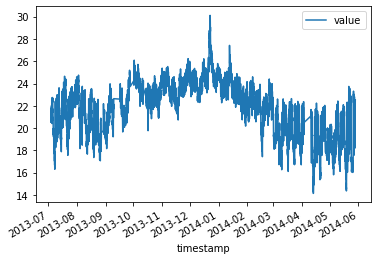

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['value'] = (df['value'] - 32) * 5/9
df.plot(x='timestamp', y='value')

# Extract useful features

Extracting the following useful features :

**1. Hours** - 24 hours (0-23) \

**2. Daytime** - \
 Daytime = 1 , if hour is in 7:00 AM to 10:00 PM \
 Daytime = 0 , otherwise (Night_time) \

**3. DayOfTheWeek** -  ( Monday - 0 )  to (Sunday - 6) \

**4. WeekDay** - \
WeekDay = 1 , if Day of week < 5 \
WeekDay = 0 , Otherwise (saturday and sunday)

**5. categories** - \
0 - Week end night \
1 - Week end daytime \
2 - Week day night \
3 - Week day day time \


In [ ]:
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

In [ ]:
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)

In [ ]:
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

In [ ]:
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

In [ ]:
df.to_csv("data1.csv",index=None)

# Long Short term memory (LSTM) model -1

 - Anomaly detection using time series forecasting

**# Read the data**

In [ ]:
df = pd.read_csv("data1.csv")

In [ ]:
df.head()

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,categories
0,2013-07-04 00:00:00,21.044908,0,0,3,1,13728960,2
1,2013-07-04 01:00:00,21.789015,1,0,3,1,13728996,2
2,2013-07-04 02:00:00,21.598781,2,0,3,1,13729032,2
3,2013-07-04 03:00:00,20.533000,3,0,3,1,13729068,2
4,2013-07-04 04:00:00,20.713084,4,0,3,1,13729104,2


**# Standardize data**

Standardize features by removing the mean and scaling to unit variance. \

In [ ]:
data_n = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay','categories']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

In [ ]:
data_n.head(5)

,0,1,2,3,4,5
0,-0.320586,-1.661537,-1.414798,0.005769,0.62132,-0.108248
1,-0.005228,-1.517172,-1.414798,0.005769,0.62132,-0.108248
2,-0.085851,-1.372807,-1.414798,0.005769,0.62132,-0.108248
3,-0.537536,-1.228442,-1.414798,0.005769,0.62132,-0.108248
4,-0.461215,-1.084077,-1.414798,0.005769,0.62132,-0.108248


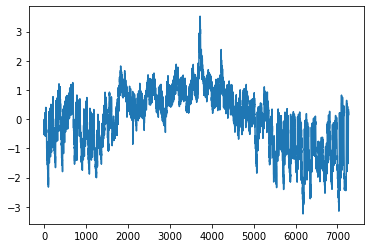

In [ ]:
plt.plot(data_n[0])

**Time Series Lag Scatter Plots**

 - Time series modeling assumes a relationship between an observation and the previous observation.

 - If the points cluster along a diagonal line from the bottom-left to the top-right of the plot, it suggests a positive correlation relationship.

 - If the points cluster along a diagonal line from the top-left to the bottom-right, it suggests a negative correlation relationship.


**Example -**

**Series** \
 {1,2,3,4,5,6,7,8,9}

**Lagged version of series** \
 {1,2,3,4,5,6,7,8} \
 {2,3,4,5,6,7,8,9}

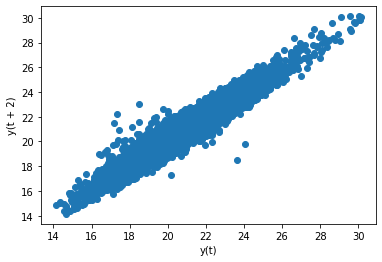

In [ ]:
pd.plotting.lag_plot(df['value'], lag=2)

# Prepare data set for time series forecasting

**# split the data set into train and test set** \

Train set - (input_train, output_train) \
test set - (input_test, output_test)  \
 
**# dataset** 

In [ ]:
data_n.shape

(7267, 6)

In [ ]:
# important parameters
prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#train data
x_train = data_n[0:-prediction_time-testdatacut].values
y_train = data_n[prediction_time:-testdatacut  ][0].values

# test data
x_test = data_n[0-testdatacut:-prediction_time].values
y_test = data_n[prediction_time-testdatacut:  ][0].values

In [ ]:
data_n.head()

,0,1,2,3,4,5
0,-0.320586,-1.661537,-1.414798,0.005769,0.62132,-0.108248
1,-0.005228,-1.517172,-1.414798,0.005769,0.62132,-0.108248
2,-0.085851,-1.372807,-1.414798,0.005769,0.62132,-0.108248
3,-0.537536,-1.228442,-1.414798,0.005769,0.62132,-0.108248
4,-0.461215,-1.084077,-1.414798,0.005769,0.62132,-0.108248


In [ ]:
print(x_train[0])
print(x_train[1])
print(x_train[2])
print(x_train[3])
print(x_train[4])

[-0.32058581 -1.66153683 -1.41479759  0.00576899  0.62131999 -0.10824848]
[-0.00522828 -1.51717197 -1.41479759  0.00576899  0.62131999 -0.10824848]
[-0.08585098 -1.37280711 -1.41479759  0.00576899  0.62131999 -0.10824848]
[-0.53753615 -1.22844225 -1.41479759  0.00576899  0.62131999 -0.10824848]
[-0.46121534 -1.08407739 -1.41479759  0.00576899  0.62131999 -0.10824848]


In [ ]:
print(y_train[0])
print(y_train[1])
print(y_train[2])
print(y_train[3])
print(y_train[4])

-0.005228281827377506
-0.08585097833639213
-0.537536152011907
-0.4612153358440551
-0.27817435608313573


**# size of train and test data set**

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(6215, 6)
(6215,)
(1050, 6)
(1050,)


**# windowing**

Window size = 50

In [ ]:
#windowing
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

**# shape of data**

In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (6165, 50, 6)
y_train (6165,)
x_test (1000, 50, 6)
y_test (1000,)


# LSTM model -1




In [ ]:
model1 = Sequential()
model1.add(LSTM(30,input_dim=x_train.shape[-1],return_sequences=True))
model1.add(Dropout(0.5))
model1.add(LSTM(30,return_sequences=False))
model1.add(Dropout(0.5))
model1.add(Dense(units=1))
model1.add(Activation('linear'))
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 30)          4440      
_________________________________________________________________
dropout (Dropout)            (None, None, 30)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 11,791
Trainable params: 11,791
Non-trainable params: 0
____________________________________________________

In [ ]:
x_train.shape

(6165, 50, 6)

**# compile the model**

In [ ]:
start = time.time()
model1.compile(loss='mse', optimizer='adam')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.01616692543029785


**# Train the model**

In [ ]:
model1.fit(
    x_train,
    y_train,
    batch_size=3000,
    epochs=20,
    validation_split=0.1)

Epoch 1/20
2/2 [==============================] - 7s 2s/step - loss: 0.7489 - val_loss: 1.1659
Epoch 2/20
2/2 [==============================] - 2s 812ms/step - loss: 0.6253 - val_loss: 1.0418
Epoch 3/20
2/2 [==============================] - 2s 827ms/step - loss: 0.5292 - val_loss: 0.9339
Epoch 4/20
2/2 [==============================] - 2s 805ms/step - loss: 0.4455 - val_loss: 0.8407
Epoch 5/20
2/2 [==============================] - 2s 832ms/step - loss: 0.3564 - val_loss: 0.7574
Epoch 6/20
2/2 [==============================] - 2s 824ms/step - loss: 0.3087 - val_loss: 0.6763
Epoch 7/20
2/2 [==============================] - 2s 835ms/step - loss: 0.2636 - val_loss: 0.5910
Epoch 8/20
2/2 [==============================] - 2s 852ms/step - loss: 0.2356 - val_loss: 0.5034
Epoch 9/20
2/2 [==============================] - 2s 831ms/step - loss: 0.2219 - val_loss: 0.4197
Epoch 10/20
2/2 [==============================] - 2s 844ms/step - loss: 0.2104 - val_loss: 0.3500
Epoch 11/20
2/2 [=====

# Predict model on train and test data 

 **- Difference between prediction and test data**

In [ ]:
loaded_model = model1
diff=[]
p = loaded_model.predict(x_test)
q = loaded_model.predict(x_train)
for u in range(len(y_test)):
    pr = p[u][0]
    diff.append(abs(y_test[u]- pr))

**# Plot the prediction and the reality (for the test data)**

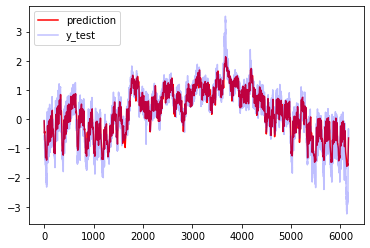

In [ ]:
 #plot the prediction and the reality (for the test data)
fig, axs = plt.subplots()
axs.plot(q,color='red', label='prediction')
axs.plot(y_train,color='blue',alpha = 0.25, label='y_test')
plt.legend(loc='upper left')
plt.show()

In [ ]:
#Pick the most distant prediction/reality data points as anomalies
outlier=0.1
diff = pd.Series(diff)
number_of_outliers = int(outlier*len(diff))
threshold = diff.nlargest(number_of_outliers).min()
#Data with anomaly label
test = (diff >= threshold).astype(int)
pred=pd.DataFrame({'B' : test,'C' : y_test,'A': df.iloc[-1001:-1,6:7].values.flatten()})
#pred.append(test, ignore_index='True')

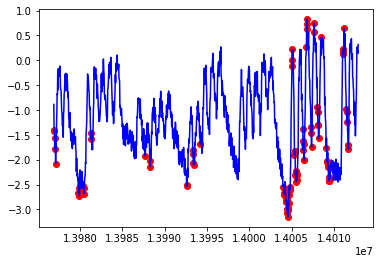

In [ ]:
fig, ax = plt.subplots()

a = pred.loc[pred['B'] == 1, ['A', 'C']] #anomaly

ax.plot(pred['A'], pred['C'], color='blue')
ax.scatter(a['A'],a['C'], color='red')
plt.show()

# LSTM model - 2

In [ ]:
model2 = Sequential()
model2.add(LSTM(128,input_dim=x_train.shape[-1],return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(128,return_sequences=False))
model2.add(Dropout(0.2))
model2.add(Dense(units=1))
model2.add(Activation('linear'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 128)         69120     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 200,833
Trainable params: 200,833
Non-trainable params: 0
________________________________________________

In [ ]:
start = time.time()
model2.compile(loss='mse', optimizer='adam')

In [ ]:
model2.fit(
    x_train,
    y_train,
    batch_size=3000,
    epochs=20,
    validation_split=0.1)

Epoch 1/20
2/2 [==============================] - 15s 6s/step - loss: 0.7670 - val_loss: 0.8603
Epoch 2/20
2/2 [==============================] - 10s 5s/step - loss: 0.3645 - val_loss: 0.5149
Epoch 3/20
2/2 [==============================] - 10s 5s/step - loss: 0.1912 - val_loss: 0.2702
Epoch 4/20
2/2 [==============================] - 10s 5s/step - loss: 0.1503 - val_loss: 0.2208
Epoch 5/20
2/2 [==============================] - 10s 5s/step - loss: 0.1090 - val_loss: 0.1777
Epoch 6/20
2/2 [==============================] - 10s 5s/step - loss: 0.1153 - val_loss: 0.1577
Epoch 7/20
2/2 [==============================] - 10s 5s/step - loss: 0.1106 - val_loss: 0.1588
Epoch 8/20
2/2 [==============================] - 10s 5s/step - loss: 0.0897 - val_loss: 0.1566
Epoch 9/20
2/2 [==============================] - 10s 5s/step - loss: 0.0870 - val_loss: 0.1591
Epoch 10/20
2/2 [==============================] - 10s 5s/step - loss: 0.0898 - val_loss: 0.1723
Epoch 11/20
2/2 [======================

In [ ]:
loaded_model = model2
diff=[]
p = loaded_model.predict(x_test)
q = loaded_model.predict(x_train)
for u in range(len(y_test)):
    pr = p[u][0]
    diff.append(abs(y_test[u]- pr))

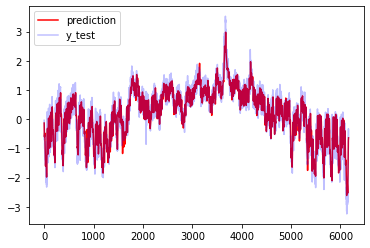

In [ ]:
 #plot the prediction and the reality (for the test data)
fig, axs = plt.subplots()
axs.plot(q,color='red', label='prediction')
axs.plot(y_train,color='blue',alpha = 0.25, label='y_test')
plt.legend(loc='upper left')
plt.show()

In [ ]:
#Pick the most distant prediction/reality data points as anomalies
outlier=0.1
diff = pd.Series(diff)
number_of_outliers = int(outlier*len(diff))
threshold = diff.nlargest(number_of_outliers).min()
#Data with anomaly label
test = (diff >= threshold).astype(int)
pred=pd.DataFrame({'B' : test,'C' : y_test,'A': df.iloc[-1001:-1,6:7].values.flatten()})
#pred.append(test, ignore_index='True')

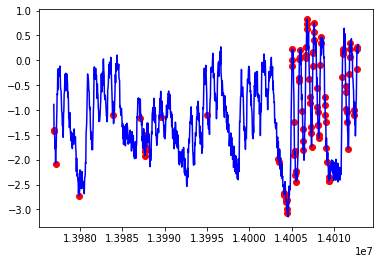

In [ ]:
fig, ax = plt.subplots()

a = pred.loc[pred['B'] == 1, ['A', 'C']] #anomaly

ax.plot(pred['A'], pred['C'], color='blue')
ax.scatter(a['A'],a['C'], color='red')
plt.show()